##### Sami Ramzi Chibane © 

##### Ce bloc-notes utilise pandana (v0.6.1) pour télécharger les données du réseau routier et des points d'intérêt à partir d'OpenStreetMap, puis calculer l'accessibilité du réseau aux points d'intérêt.

In [20]:
import pandana, matplotlib.pyplot as plt
from pandana.loaders import osm
%matplotlib inline

##### Remarque/ il est possible de générer les cordoonées de la bbox qui vous intéresse sur ce site  :  https://boundingbox.klokantech.com/
##### Ensuite, il faut insérer les cordonnées dans l'ordre suivant : "Sud, Ouest, Nord, Est" au lieu de l'ordre proposé par le site boundingbox : "Ouest, Sud, Est, Nord"

#### L'exemple des "restaurants" à Grenoble en France

In [2]:
bbox = [45.140656,5.687512,45.212777, 5.775403] #lat-long bounding box pour Grenoble
amenity = 'restaurant' 
distance = 1500 #distance maximale en mètres

##### Téléchargement des points d'intérêt (POI) et des données réseau depuis OpenStreetMap

##### Téléchargez d'abord les points d'intérêt correspondant au type d'aménité spécifiée

In [3]:
pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags='"amenity"="{}"'.format(amenity))
pois[['amenity', 'name', 'lat', 'lon']].tail()

,amenity,name,lat,lon
id,,,,
9550138455,restaurant,Pizza Cosy,45.189960,5.715901
9551747425,restaurant,Les Alpins,45.168668,5.720174
9554402835,restaurant,Le Panier des saveurs,45.178561,5.729814
9665629791,restaurant,Bui'strot,45.200683,5.706874
9709473839,restaurant,NaN,45.175332,5.746068


In [4]:
# Interrogons l'API OSM pour le réseau routier dans le cadre de délimitation spécifiée
network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])

# Affichons le nombre de nœuds du réseau obtenu pour cette bbox 
len(network.node_ids)

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:147: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will b

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](45.14065600,5.68751200,45.21277700,5.77540300);>;);out;'}"
Downloaded 18,757.7KB from www.overpass-api.de in 13.27 seconds


C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:171: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  ' {:,.2f} seconds'.format(len(geometry), time.time()-start_time))


Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 14.05 seconds
Returning OSM data with 104,015 nodes and 27,314 ways...
Edge node pairs completed. Took 42.79 seconds
Returning processed graph with 36,592 nodes and 53,841 edges...
Completed OSM data download and Pandana node and edge table creation in 60.44 seconds


36592

#### Traitement des données du réseau puis calcule de l'accessibilité

In [5]:
# Identifions les nœuds qui sont connectés à moins d'un certain seuil d'autres nœuds à une distance donnée
# Ne rien faire avec cela pour l'instant, mais voir l'exemple complet dans un autre carnet pour aller plus loin
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

In [6]:
# Précalculons les requêtes de plage (les nœuds accessibles à cette distance maximale)
network.precompute(distance + 1)

In [7]:
# Initialisez ensuite le moteur de points d'intérêt C++ sous-jacent
network.init_pois(num_categories=1, max_dist=distance, max_pois=7)

In [8]:
# Initialisez une catégorie pour cet équipement avec les emplacements spécifiés par les colonnes longitude et latitude
network.set_pois(category='my_amenity', x_col=pois['lon'], y_col=pois['lat'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [9]:
# Recherchez les n commodités les plus proches de chaque nœud du réseau
access = network.nearest_pois(distance=distance, category='my_amenity', num_pois=7)

# chaque cellule dataframe représente la distance du réseau entre le nœud et chacun des n POI
access.head()

,1,2,3,4,5,6,7
id,,,,,,,
124550,337.859985,373.321014,620.294006,711.122986,739.182007,883.020020,1024.579956
124551,284.214996,487.326996,503.393005,578.156006,606.215027,750.052979,891.612976
124552,414.622986,468.975006,477.647003,510.122009,617.734985,681.625000,763.044983
124553,352.420013,541.487000,544.916992,633.812012,642.859009,743.695007,793.656006
124554,25.323000,53.341000,53.341000,712.567017,795.783997,869.440002,954.395020


#### Tracer l'accessibilité

In [10]:
# Arguments des paramètres à passer pour la figure matplotlib
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# Arguments des paramètres à passer pour les nuages de points
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

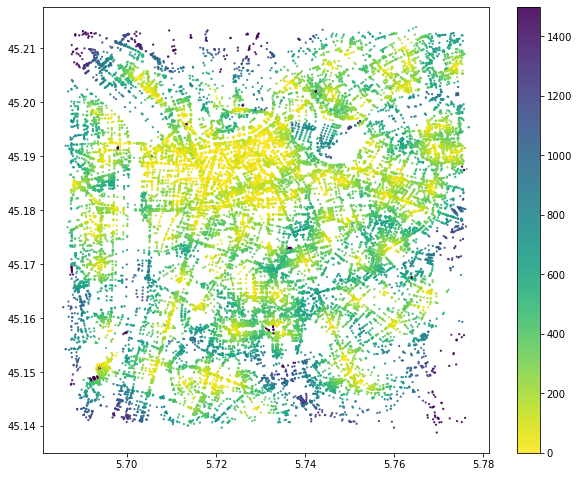

ValueError: not enough values to unpack (expected 3, got 2)

In [19]:
# Tracez la distance jusqu'à la nième aménité la plus proche
n = 1
bmap, fig, ax = network.plot(access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_axis_bgcolor('k')
fig.savefig('images/accessibility-pub-east-bay.png', dpi=200, bbox_inches='tight')
plt.show()

#### L'exemple des "cafétéria" à Paris en France

In [21]:
bbox = [48.81629,2.253421,48.902461, 2.416499] #lat-long bounding box pour Grenoble
amenity = 'cafe' 
distance = 1500 #distance maximale en mètres

In [22]:
pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags='"amenity"="{}"'.format(amenity))
pois[['amenity', 'name', 'lat', 'lon']].tail()

,amenity,name,lat,lon
id,,,,
9664183417,cafe,JOZI Café,48.847864,2.347091
9664253417,cafe,Saint Laurent Café,48.865179,2.330757
9672800538,cafe,de Voltaire à Rousseau,48.862174,2.339999
9679355233,cafe,Brasilia,48.869270,2.333135
9679815246,cafe,Bulle,48.857237,2.359155


In [23]:
# Interrogons l'API OSM pour le réseau routier dans le cadre de délimitation spécifiée
network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])

# Affichons le nombre de nœuds du réseau obtenu pour cette bbox 
len(network.node_ids)

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:147: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will b

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](48.81629000,2.25342100,48.90246100,2.41649900);>;);out;'}"
Downloaded 43,210.5KB from www.overpass-api.de in 12.00 seconds


C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:171: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  ' {:,.2f} seconds'.format(len(geometry), time.time()-start_time))


Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 12.91 seconds
Returning OSM data with 240,677 nodes and 55,411 ways...
Edge node pairs completed. Took 102.91 seconds
Returning processed graph with 67,399 nodes and 100,512 edges...
Completed OSM data download and Pandana node and edge table creation in 118.83 seconds


67399

In [24]:
# Identifions les nœuds qui sont connectés à moins d'un certain seuil d'autres nœuds à une distance donnée
# Ne rien faire avec cela pour l'instant, mais voir l'exemple complet dans un autre carnet pour aller plus loin
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

In [25]:
# Précalculons les requêtes de plage (les nœuds accessibles à cette distance maximale)
network.precompute(distance + 1)

In [26]:
# Initialisez ensuite le moteur de points d'intérêt C++ sous-jacent
network.init_pois(num_categories=1, max_dist=distance, max_pois=7)

In [27]:
# Initialisez une catégorie pour cet équipement avec les emplacements spécifiés par les colonnes longitude et latitude
network.set_pois(category='my_amenity', x_col=pois['lon'], y_col=pois['lat'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [28]:
# Recherchez les n commodités les plus proches de chaque nœud du réseau
access = network.nearest_pois(distance=distance, category='my_amenity', num_pois=7)

# chaque cellule dataframe représente la distance du réseau entre le nœud et chacun des n POI
access.head()

,1,2,3,4,5,6,7
id,,,,,,,
125728,347.023010,440.384003,461.640015,624.294006,670.239990,751.015015,810.776978
125730,489.756989,554.638977,604.374023,771.927979,817.874023,898.648987,953.510986
125742,0.000000,108.235001,130.725998,203.824997,217.565994,241.977005,265.584991
125747,304.083008,331.864014,406.811005,640.546021,852.901978,881.997986,1011.729980
125760,524.596008,789.124023,847.869019,854.362000,993.913025,1010.062988,1025.608032


In [31]:
# Arguments des paramètres à passer pour la figure matplotlib
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(40, 40 * bbox_aspect_ratio)}

# Arguments des paramètres à passer pour les nuages de points
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

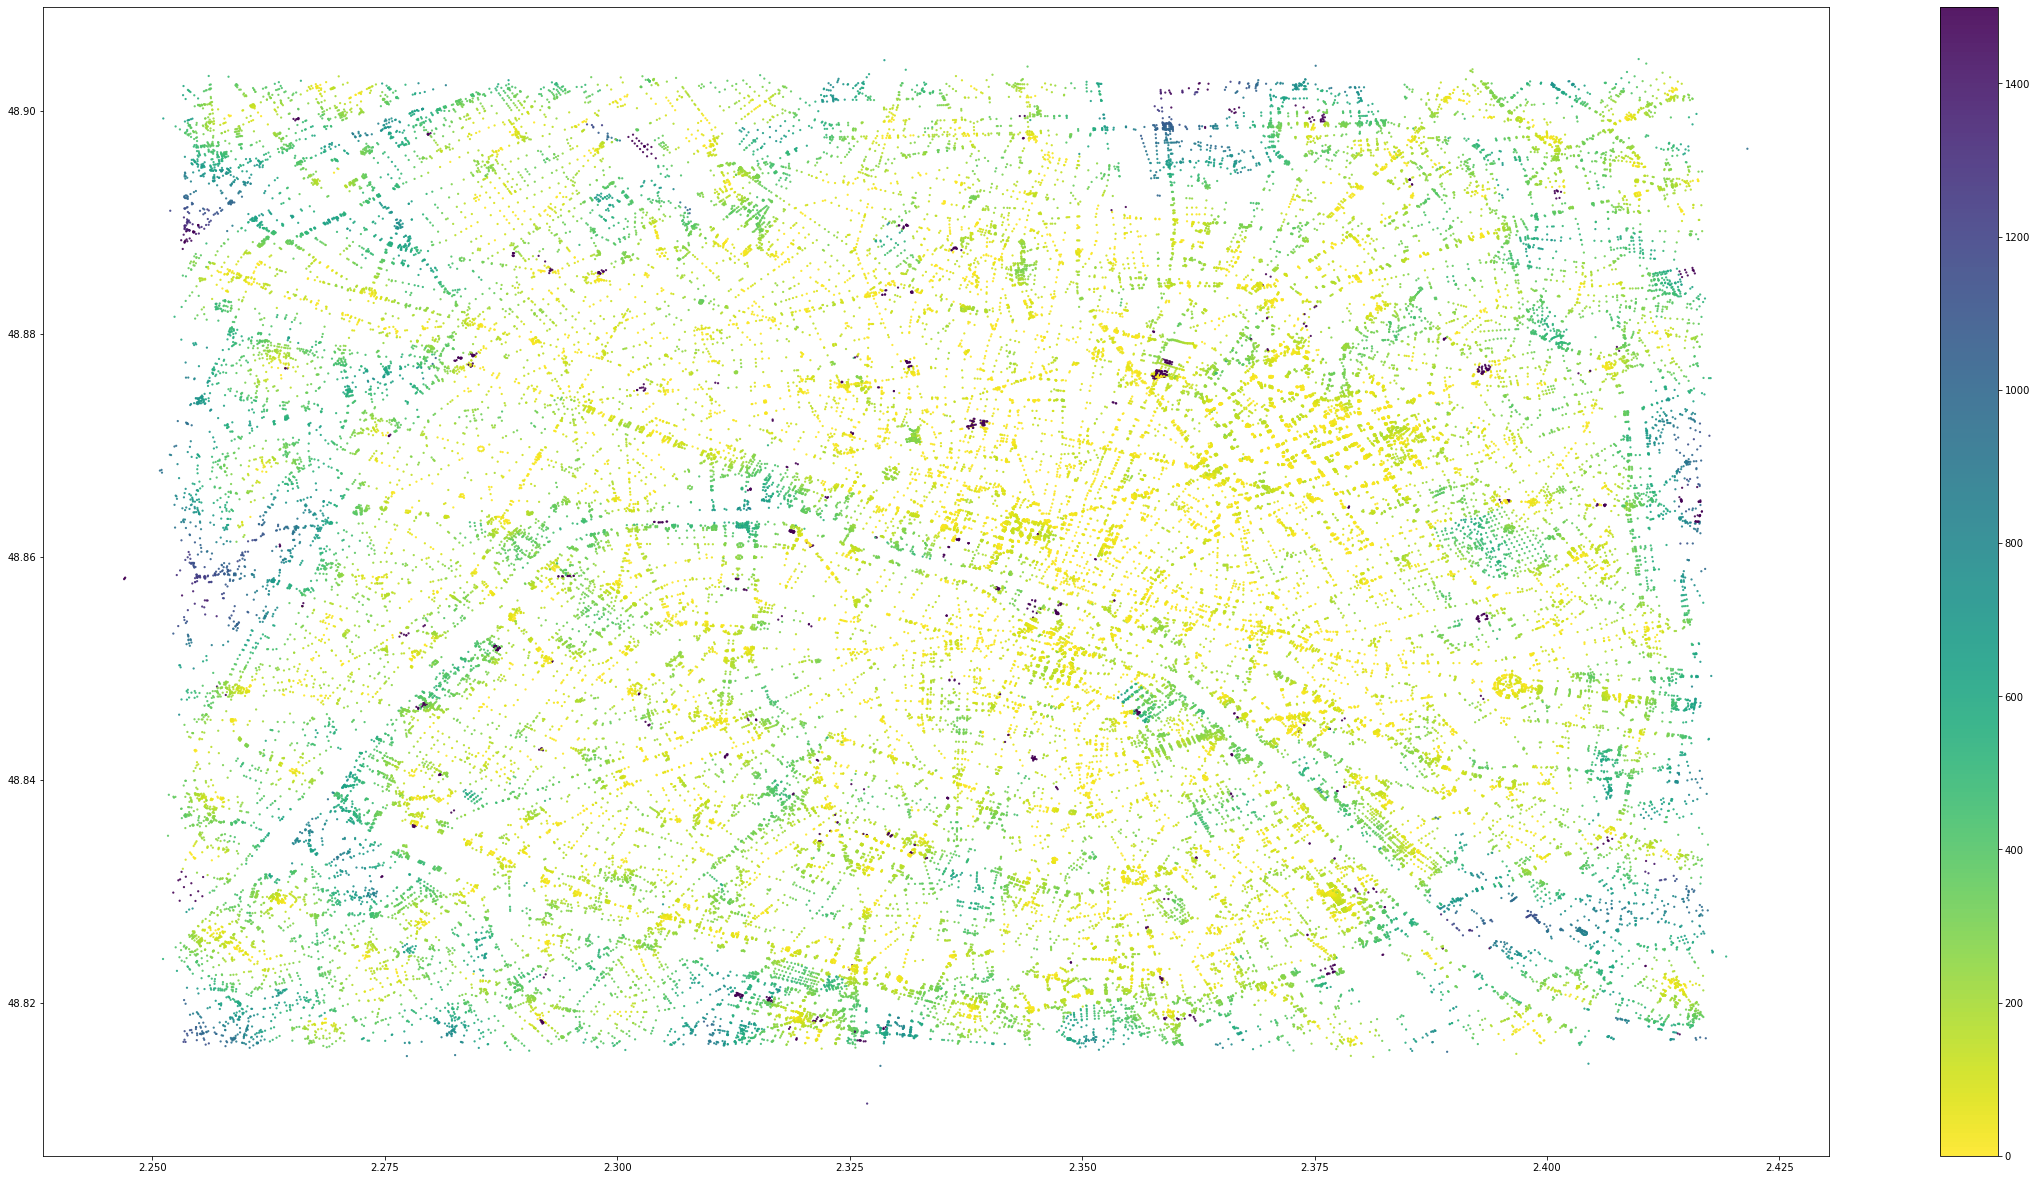

ValueError: not enough values to unpack (expected 3, got 2)

In [32]:
# Tracez la distance jusqu'à la nième aménité la plus proche
n = 1
bmap, fig, ax = network.plot(access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_axis_bgcolor('k')
fig.savefig('images/accessibility-cafe-east-bay.png', dpi=200, bbox_inches='tight')
plt.show()

##### Requêtes d'agrégation de réseau

In [33]:
# Obtenez d'abord le node_id le plus proche pour chaque point d'intérêt, en fonction de sa lat-lon
pois['node_ids'] = network.get_node_ids(pois['lon'], pois['lat'])

In [34]:
network.set(pois['node_ids'], variable=pois['capacity'], name='capacity')

Removed 2039 rows because they contain missing values


In [35]:
capacity_sum = network.aggregate(distance=distance, type='sum', decay='linear', name='capacity')

In [37]:
# les tracés d'agrégation de réseau sont les mêmes que les tracés de dispersion réguliers, mais sans palette de couleurs inversée
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

In [41]:
cbar_kwargs = {}

In [42]:
# arguments des paramètres à transmettre au fond de carte
bmap_kwargs = {}

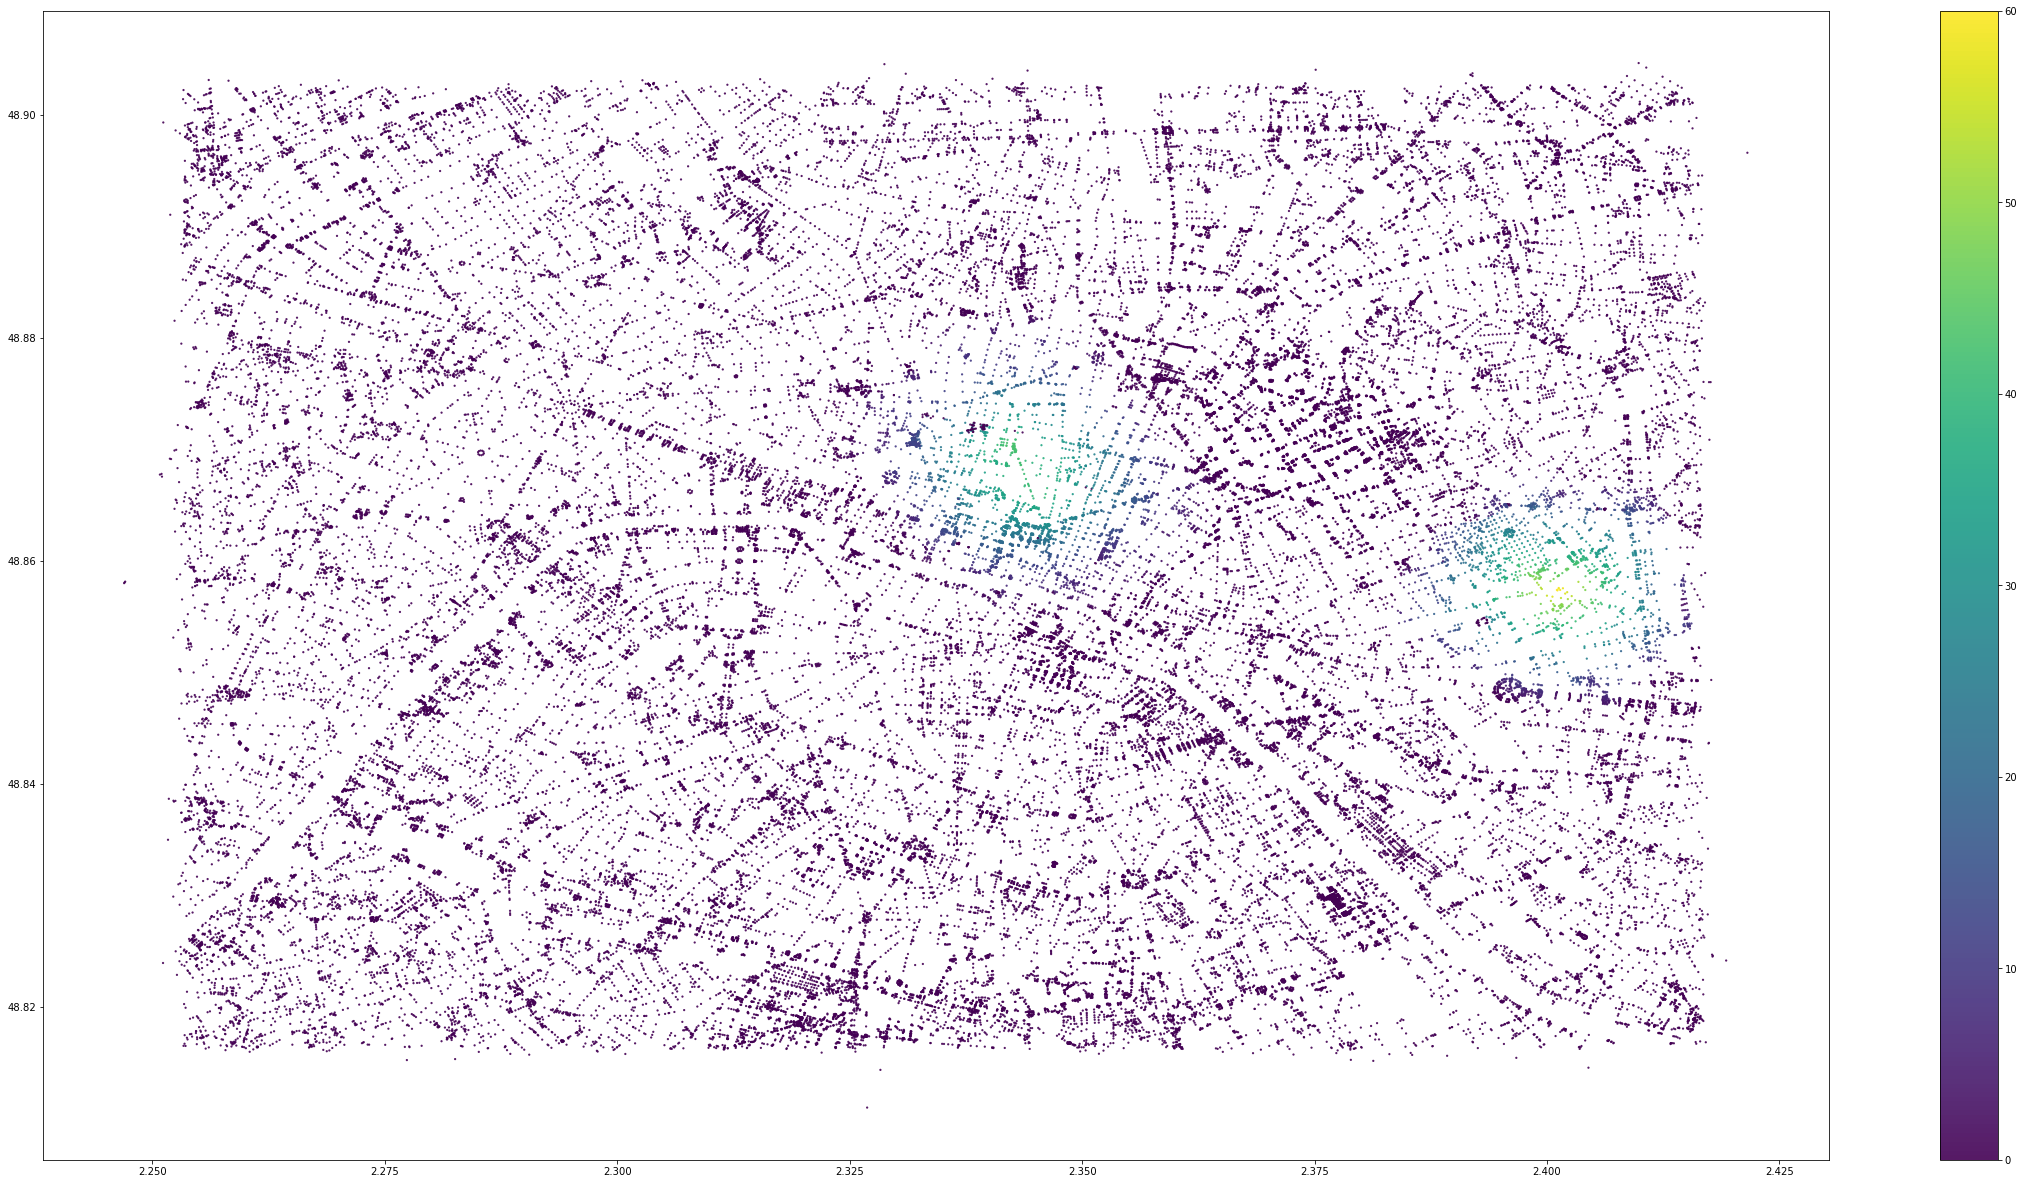

ValueError: not enough values to unpack (expected 3, got 2)

In [44]:
bmap, fig, ax = network.plot(capacity_sum, bbox=bbox, plot_type='scatter', plot_kwargs=agg_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)